In [1]:
import torch
import torch.nn as nn
import torchvision.models as models

class ViTWithHead(nn.Module):
    def __init__(self, hidden_layer_sizes, dropout_rate, num_classes, pretrained=True):
        super(ViTWithHead, self).__init__()

        # Load the pretrained Vision Transformer backbone
        if pretrained:
            self.backbone = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
        else:
            self.backbone = models.vit_b_16(weights=None)

        # ViT model does not use a classifier like DenseNet, but outputs a tensor directly
        num_features = self.backbone.heads[0].in_features  # Assuming the ViT model ends with a linear layer

        # Remove the last classification head of the backbone (if exists)
        self.backbone.heads = nn.Identity()

        # Custom head with hidden layers
        layers = []
        input_size = num_features

        for size in hidden_layer_sizes:
            linear_layer = nn.Linear(input_size, size)
            torch.nn.init.kaiming_uniform_(linear_layer.weight, nonlinearity='relu')
            layers.append(linear_layer)
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(size))
            layers.append(nn.Dropout(dropout_rate))
            input_size = size

        # Output layer
        layers.append(nn.Linear(input_size, num_classes))

        # Assemble the custom head
        self.custom_head = nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass through the backbone
        features = self.backbone(x)

        # The output from ViT is usually a tuple, we need only the last hidden state
        if isinstance(features, tuple):
            features = features[0]  # Getting the last hidden state

        # Forward pass through the custom head
        output = self.custom_head(features)

        return output


/h/hhamidi/storage/miniconda3/envs/ldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
import torch
import torch.nn as nn
from torchvision.models import vit_b_16

class ViTWithHead(nn.Module):
    def __init__(self, hidden_layer_sizes, dropout_rate, num_classes, pretrained=True):
        super(ViTWithHead, self).__init__()

        # Load the pretrained Vision Transformer backbone
    
        self.backbone = vit_b_16(pretrained=pretrained)

        # Assuming the ViT model ends with a linear layer and we only use the head output
        num_features = self.backbone.heads[0].in_features

        # Remove the last classification head of the backbone (if exists)
        self.backbone.heads = nn.Identity()

        # Custom head with hidden layers
        layers = []
        input_size = num_features
        for size in hidden_layer_sizes:
            linear_layer = nn.Linear(input_size, size)
            torch.nn.init.kaiming_uniform_(linear_layer.weight, nonlinearity='relu')
            layers.append(linear_layer)
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(size))
            layers.append(nn.Dropout(dropout_rate))
            input_size = size

        # Output layer
        layers.append(nn.Linear(input_size, num_classes))

        # Assemble the custom head
        self.custom_head = nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass through the backbone
        features = self.backbone(x)

        # The output from ViT is usually a tuple, we need only the last hidden state
        if isinstance(features, tuple):
            features = features[0]  # Getting the last hidden state

        # Forward pass through the custom head
        output = self.custom_head(features)

        return output

# Test parameters
hidden_layer_sizes = [512, 256]  # Example sizes of hidden layers
dropout_rate = 0.5
num_classes = 14
pretrained = False  # Set to False for testing without downloading weights

# Initialize the model
model = ViTWithHead(hidden_layer_sizes, dropout_rate, num_classes, pretrained)

# Create a random input tensor of size (batch_size, channels, height, width)
# The dimensions need to match the expected input dimensions of the ViT model, typically (3, 224, 224)
input_tensor = torch.randn(4, 3, 224, 224)  # Example with batch size of 4

# Forward pass
output = model(input_tensor)

# Check the output shape
print("Output shape:", output.shape)  # Expected shape: (4, num_classes)
assert output.shape == (4, num_classes), "Output shape is incorrect"

print("Test passed!")


Output shape: torch.Size([4, 14])
Test passed!


(320, 390)


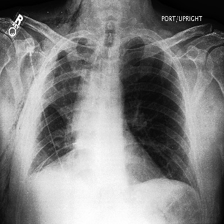

In [32]:
# read this /datasets/chexpert/CheXpert-v1.0-small/train/patient12347/study1/view1_frontal.jpg



import numpy as np
from PIL import Image


image = Image.open('/datasets/chexpert/CheXpert-v1.0-small/train/patient12348/study5/view1_frontal.jpg')
# print shape
print(np.array(image).shape)
image.resize((224, 224))

In [33]:
# read this 
import pandas as pd
valid = pd.read_csv('/datasets/chexpert/CheXpert-v1.0-small/valid.csv')

In [36]:
valid['Frontal/Lateral']

0      Frontal
1      Frontal
2      Lateral
3      Frontal
4      Frontal
        ...   
229    Frontal
230    Frontal
231    Frontal
232    Frontal
233    Frontal
Name: Frontal/Lateral, Length: 234, dtype: object

In [29]:
# class CLS image classification
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torch.nn.init as init
import torchvision.models as models
from PIL import Image
from imageio import imread


class CLS():
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.LABEL_NAMES =['Atelectasis',
                            'Cardiomegaly',
                            'Consolidation',
                            'Edema',
                            'Enlarged Cardiomediastinum',
                            'Fracture',
                            'Lung Lesion',
                            'Lung Opacity',
                            'No Finding',
                            'Pleural Effusion',
                            'Pleural Other',
                            'Pneumonia',
                            'Pneumothorax',
                            'Support Devices']

    def predict(self, image_path):

        transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize([224, 224]),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        image = imread(image_path)
        if len(image.shape) == 2:  # Handle grayscale images
            image = np.stack([image] * 3, axis=-1)
        image = Image.fromarray(image)
        image = transform(image)

        




        # Move the tensor to the device
        image = image.to(self.device)

        # Set the model to evaluation mode
        self.model.eval()

        # Perform the forward pass
        with torch.no_grad():
            output = self.model(image[None, ...])
        # apply sigmoid as the the loss function was BCEWithLogitsLoss
        output = torch.sigmoid(output)
        # create a dictionary of the labels and predictions
        result = dict(zip(self.LABEL_NAMES, output[0].tolist()))
        

        

        return result
    

class DensNetWithHead(nn.Module):
    def __init__(self,  hidden_layer_sizes, dropout_rate, num_classes):
        super(DensNetWithHead, self).__init__()

        # Pretrained DenseNet backbone
        self.backbone = models.densenet121(pretrained=True)
        num_features = self.backbone.classifier.in_features

        # Remove the last classification layer of the backbone
        self.backbone.classifier = nn.Identity()

        # Custom head with hidden layers
        layers = []
        input_size = num_features

        for size in hidden_layer_sizes:
            linear_layer = nn.Linear(input_size, size)
            init.kaiming_uniform_(linear_layer.weight, nonlinearity='relu')
            layers.append(linear_layer)
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(size))
            layers.append(nn.Dropout(dropout_rate))
            input_size = size

        # Output layer
        layers.append(nn.Linear(input_size, num_classes))

        # Assemble the custom head
        self.custom_head = nn.Sequential(*layers)

    def forward(self, x):
        # Forward pass through the backbone
        features = self.backbone(x)
  

        # Forward pass through the custom head
        output = self.custom_head(features)

        return output




In [19]:
# Test parameters
hidden_layer_sizes = [768, 128]  # Example sizes of hidden layers
dropout_rate = 0.1
num_classes = 14
# /fs01/home/hhamidi/fairness_on_embeddings/results/image_chexpert_real_real/checkpoints/best_val_loss-epoch=61-val_loss=0.2600.ckpt
# Initialize the model
model = DensNetWithHead(hidden_layer_sizes, dropout_rate, num_classes)

In [20]:
# load the model weights
# remove the model. from the keys

state_dict = torch.load('/fs01/home/hhamidi/fairness_on_embeddings/results/image_chexpert_real_real/checkpoints/best_val_loss-epoch=61-val_loss=0.2600.ckpt')['state_dict']

new_state_dict = {}
for k, v in state_dict.items():
    name = k.replace('model.', '')
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [31]:
# apply sigmoid to the output
model = model.to('cuda')
cls = CLS(model, 'cuda')
output = cls.predict('/datasets/chexpert/CheXpert-v1.0-small/train/patient12348/study5/view1_frontal.jpg')
print(output)


{'Atelectasis': 0.0374627523124218, 'Cardiomegaly': 0.001316045061685145, 'Consolidation': 0.018886752426624298, 'Edema': 0.04958276450634003, 'Enlarged Cardiomediastinum': 0.0035565488506108522, 'Fracture': 0.0003621174837462604, 'Lung Lesion': 1.2338021406321786e-05, 'Lung Opacity': 0.14163558185100555, 'No Finding': 0.0014445279957726598, 'Pleural Effusion': 0.07595134526491165, 'Pleural Other': 0.05671478062868118, 'Pneumonia': 0.00021282017405610532, 'Pneumothorax': 0.7999169230461121, 'Support Devices': 0.3527168333530426}


labels: 
 {'Atelectasis': 0.0, 'Cardiomegaly': 0.0, 'Consolidation': 0.0, 'Edema': 0.0, 'Enlarged Cardiomediastinum': 0.0, 'Fracture': 0.0, 'Lung Lesion': 0.0, 'Lung Opacity': 0.0, 'No Finding': 1.0, 'Pleural Effusion': 0.0, 'Pleural Other': 0.0, 'Pneumonia': 0.0, 'Pneumothorax': 0.0, 'Support Devices': 0.0}
predictions: 
 {'Atelectasis': 0.30474090576171875, 'Cardiomegaly': 0.003529257606714964, 'Consolidation': 0.1779017597436905, 'Edema': 0.09431736171245575, 'Enlarged Cardiomediastinum': 0.04191034659743309, 'Fracture': 0.00984462071210146, 'Lung Lesion': 0.024487826973199844, 'Lung Opacity': 0.84130859375, 'No Finding': 0.00041896937182173133, 'Pleural Effusion': 0.02835402823984623, 'Pleural Other': 4.9459376896265894e-05, 'Pneumonia': 0.20496737957000732, 'Pneumothorax': 0.8321113586425781, 'Support Devices': 0.11139632016420364}


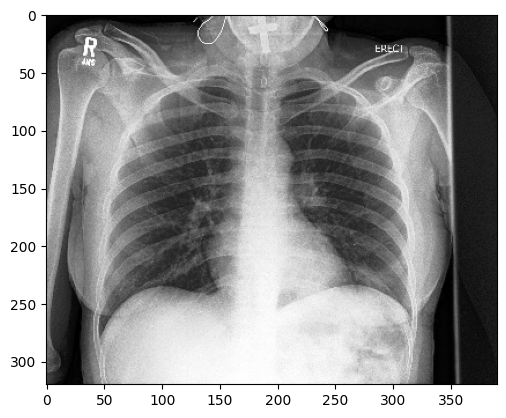

In [40]:
# load /fs01/home/hhamidi/projects/stable-diffusion/data/csv_files/val.csv 
import pandas as pd
val = pd.read_csv('/fs01/home/hhamidi/projects/stable-diffusion/data/csv_files/val.csv')
LABEL_NAMES =['Atelectasis',
                            'Cardiomegaly',
                            'Consolidation',
                            'Edema',
                            'Enlarged Cardiomediastinum',
                            'Fracture',
                            'Lung Lesion',
                            'Lung Opacity',
                            'No Finding',
                            'Pleural Effusion',
                            'Pleural Other',
                            'Pneumonia',
                            'Pneumothorax',
                            'Support Devices']
# index 
index = 4
# get the image path
image_path = '/datasets/chexpert/' + val['Path'][index]
# get the labels
labels = val[LABEL_NAMES].iloc[index]
# make labels a dictionary
labels = labels.to_dict()
# get the predictions
output = cls.predict(image_path)

print('labels: \n', labels)
print('predictions: \n', output)
# plot the image
import matplotlib.pyplot as plt
image = imread(image_path)
# convert to rgb
if len(image.shape) == 2:  # Handle grayscale images
    image = np.stack([image] * 3, axis=-1)
plt.imshow(image)
plt.show()

In [57]:
# run code on all the images in the validation set 
labels = []
probabilities = []

for index in range(len(val)):
    image_path = '/datasets/chexpert/' + val['Path'][index]
    label = val[LABEL_NAMES].iloc[index]
    labels.append(list(label.values))
    output = cls.predict(image_path)
    probabilities.append(list(output.values()))
    print(index,end=' ')




0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 

In [62]:
np.array(probabilities).shape , np.array(labels).shape

((234, 14), (234, 14))

In [68]:
# import fs01/home/hhamidi/fairness_on_embeddings/metrics/metrics.py
from metrics.metrics import calculate_roc_auc,find_best_threshold,calculate_fpr_fnr

# calculate the roc auc
thersholds = find_best_threshold( np.array(probabilities),np.array(labels))
print('thersholds: ', thersholds)
_,_,roc_auc = calculate_roc_auc(np.array(probabilities),np.array(labels))
print('roc_auc: ', roc_auc)



thersholds:  {0: 0.19346588850021362, 1: 0.01093992218375206, 2: 0.22252681851387024, 3: 0.5401337146759033, 4: 0.00020599737763404846, 5: 1.201941586259636e-07, 6: 3.97034345951397e-05, 7: 0.14317730069160461, 8: 0.09597134590148926, 9: 0.5359985828399658, 10: 0.35081174969673157, 11: 0.6198245882987976, 12: 0.5312337875366211, 13: 0.3775276839733124}
roc_auc:  {0: 0.7219967532467533, 1: 0.7724131821403261, 2: 0.7069199457259159, 3: 0.8289241622574955, 4: 0.5907522935779818, 5: nan, 6: 0.128755364806867, 7: 0.809156378600823, 8: 0.7418098818474759, 9: 0.8099025828939136, 10: 0.9785407725321889, 11: 0.6073008849557522, 12: 0.7621681415929203, 13: 0.8302303333578629}


/h/hhamidi/storage/miniconda3/envs/ldm/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/h/hhamidi/storage/miniconda3/envs/ldm/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


In [76]:
    # class_path: data.image.dataset_class.Chexpert
    # init_args:
    #   dataframe_path: /fs01/home/hhamidi/projects/stable-diffusion/data/csv_files/val_from_train.csv
    #   path_image: /datasets/chexpert/
    #   MAPPING:
    #     -1: 1
    #     0: 0
    #     1: 1
    #     !!float 'NaN': 0 # np.nan
    #   transform:
    #     class_path: torchvision.transforms.Compose
    #     init_args:
    #       transforms:
    #       - class_path: torchvision.transforms.Resize
    #         init_args:
    #           size: [224,224]
    #       - class_path: torchvision.transforms.ToTensor
    #       - class_path: torchvision.transforms.Normalize
    #         init_args:
    #           mean: [0.485, 0.456, 0.406]
    #           std: [0.229, 0.224, 0.225]


In [82]:
class CLS():
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.LABEL_NAMES =['Atelectasis',
                            'Cardiomegaly',
                            'Consolidation',
                            'Edema',
                            'Enlarged Cardiomediastinum',
                            'Fracture',
                            'Lung Lesion',
                            'Lung Opacity',
                            'No Finding',
                            'Pleural Effusion',
                            'Pleural Other',
                            'Pneumonia',
                            'Pneumothorax',
                            'Support Devices']
    def predict(self, image):
        image = image.to(self.device)
        self.model.eval()
        with torch.no_grad():
            if len(image.shape) == 3:
                output = self.model(image[None, ...])

                
        output = torch.sigmoid(output)
        result = dict(zip(self.LABEL_NAMES, output[0].tolist()))
        return result
    
# load the model weights
# remove the model. from the keys

state_dict = torch.load('/fs01/home/hhamidi/fairness_on_embeddings/results/image_chexpert_real_real/checkpoints/best_val_loss-epoch=61-val_loss=0.2600.ckpt')['state_dict']

new_state_dict = {}
for k, v in state_dict.items():
    name = k.replace('model.', '')
    new_state_dict[name] = v

model.load_state_dict(new_state_dict)


model = model.to('cuda')
cls = CLS(model, 'cuda')




0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 

In [84]:
np.array(labels).shape , np.array(probabilities).shape

((200, 14), (200, 14))

In [85]:
# calculate the roc auc
thersholds = find_best_threshold( np.array(probabilities),np.array(labels))
print('thersholds: ', thersholds)
_,_,roc_auc = calculate_roc_auc(np.array(probabilities),np.array(labels))
print('roc_auc: ', roc_auc)


thersholds:  {0: 0.5197364687919617, 1: 0.3391628861427307, 2: 0.3069796562194824, 3: 0.4805026054382324, 4: 0.1989464908838272, 5: 0.6327875852584839, 6: 0.3012726604938507, 7: 0.44929197430610657, 8: 0.3490808308124542, 9: 0.5921140909194946, 10: 0.3764841854572296, 11: 0.4864136576652527, 12: 0.19827041029930115, 13: 0.45005878806114197}
roc_auc:  {0: 0.9240840460352655, 1: 0.9231477220432582, 2: 0.9578321394783079, 3: 0.9680538041193778, 4: 0.9562289562289562, 5: 0.9936224489795918, 6: 0.99609375, 7: 0.9445989084543301, 8: 0.9917729329494035, 9: 0.9574318910256411, 10: 0.9974747474747474, 11: 0.9380987472365512, 12: 0.9886363636363636, 13: 0.9834666666666666}
